In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]="6"

In [2]:

import numpy as np
from matplotlib import pyplot as plt
import nibabel as nib
from PIL import Image
from matplotlib import pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from sklearn.model_selection import train_test_split
import torchsummary
from torchvision import transforms
import time
from sklearn.metrics import classification_report

In [3]:
#파일이름 sort해서 list저장
data_path='/disk1/data_liverbound_noclip/'
name_list=os.listdir(data_path)

segmentation_data = [files[:-4] for files in name_list if files.startswith('segmentation')]
segmentation_data=list(set(segmentation_data))
segmentation_data.sort()

volume_data=[files[:-4] for files in name_list if files.startswith('volume')]
volume_data=list(set(volume_data))
volume_data.sort()

In [4]:
all_labels=np.loadtxt('/home/sumins/workspace/liver_classification/all_labels.txt',dtype=int)
all_labels=all_labels.tolist()

In [6]:
#npy를 slice별로 나누어 하나의 list저장
segmentation_list=[]
for file in segmentation_data: #
    fname=os.path.basename(file)
    print(fname)
    img_array=np.load(data_path+fname+'.npy')
    
    #print(f'img_num: {img_array.shape}')
    
    if len(img_array.shape) == 3:
        nx, ny, nz = img_array.shape
        total_slices = img_array.shape[2]
        print(total_slices)
        # iterate through slices
        for current_slice in range(0, total_slices):
            segmentation_list.append(img_array[:,:,current_slice]) 
#간 1, 병변 2, 나머지 0


volume_list=[]
for file in volume_data:
    fname=os.path.basename(file)
    print(fname)
    img_array=np.load(data_path+fname+'.npy')
    
    #print(f'img_num: {img_array.shape}')
    
    if len(img_array.shape) == 3:
        nx, ny, nz = img_array.shape
        total_slices = img_array.shape[2]
        # iterate through slices
        for current_slice in range(0, total_slices):
            volume_list.append(img_array[:,:,current_slice]) 

volume-0
volume-1
volume-10
volume-100
volume-101
volume-102
volume-103
volume-104
volume-105
volume-106
volume-107
volume-108
volume-109
volume-11
volume-110
volume-111
volume-112
volume-113
volume-114


KeyboardInterrupt: 

In [29]:
#label을 만들어 list에 저장
all_labels = []
for i in segmentation_list:
    if 2 in i:
        all_labels.append(1)
    else:
        all_labels.append(0)

In [7]:
def norm(nparray):
    # normalize scans to [0,1]
    _min = nparray.min()
    _max = nparray.max()
    nparray = nparray - _min
    nparray = nparray / (_max - _min)
    return nparray

def norm_zscore(nparray):
    # normalize 2d scands by mean and standard deviation
    mean = nparray.mean()
    std = nparray.std()    
    nparray = nparray - mean
    nparray /= std
    return nparray

In [8]:
WINDOW_MAX = 200
WINDOW_MIN = 0
GLOBAL_PIXEL_MEAN = 0.1

class CustomDataset(Dataset): 
  def __init__(self,volume_list,all_labels,transforms=None):
    self.volume_list=volume_list
    self.all_labels=all_labels
    self.length=len(all_labels)
    self.transforms=transforms


  def __len__(self):
    return self.length


  def __getitem__(self, idx):
    npy=self.volume_list[idx]

    npy[npy > WINDOW_MAX] = WINDOW_MAX
    npy[npy < WINDOW_MIN] = WINDOW_MIN
    
    npy = (npy - WINDOW_MIN) / (WINDOW_MAX - WINDOW_MIN)
    npy -= GLOBAL_PIXEL_MEAN
    
    if len(npy.shape)==2:
      npy=npy[:,:,np.newaxis].astype(dtype='float32')
    
    if self.transforms is not None:
      npy=self.transforms(npy)
    
    return{'npy':npy,'label':self.all_labels[idx]}

In [9]:
class CustomConvNet(nn.Module):
    def __init__(self):
        super(CustomConvNet, self).__init__() #상속받은 class에 접근하기 위함

        self.layer1 = self.conv_module(1, 16) #grayscale
        self.layer2 = self.conv_module(16, 32)
        self.layer3 = self.conv_module(32, 64)
        self.layer4 = self.conv_module(64, 128)
        self.layer5 = self.conv_module(128, 256)
        self.gap = self.global_avg_pool(256, 2)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.gap(out)
        out = out.view(-1, 2)

        return out

    def conv_module(self, in_num, out_num):
        return nn.Sequential(
            nn.Conv2d(in_num, out_num, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_num),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

    def global_avg_pool(self, in_num, out_num):
        return nn.Sequential(
            nn.Conv2d(in_num, out_num, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_num),
            nn.LeakyReLU(),
            nn.AdaptiveAvgPool2d((1,1)))
        
model=CustomConvNet()
torchsummary.summary(model.cuda(),input_size=(1,512,512),batch_size=1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 16, 512, 512]             160
       BatchNorm2d-2          [1, 16, 512, 512]              32
         LeakyReLU-3          [1, 16, 512, 512]               0
         MaxPool2d-4          [1, 16, 256, 256]               0
            Conv2d-5          [1, 32, 256, 256]           4,640
       BatchNorm2d-6          [1, 32, 256, 256]              64
         LeakyReLU-7          [1, 32, 256, 256]               0
         MaxPool2d-8          [1, 32, 128, 128]               0
            Conv2d-9          [1, 64, 128, 128]          18,496
      BatchNorm2d-10          [1, 64, 128, 128]             128
        LeakyReLU-11          [1, 64, 128, 128]               0
        MaxPool2d-12            [1, 64, 64, 64]               0
           Conv2d-13           [1, 128, 64, 64]          73,856
      BatchNorm2d-14           [1, 128,

In [10]:
transforms_train = transforms.Compose([transforms.ToTensor()
                                       ])
transforms_test = transforms.Compose([transforms.ToTensor()
                                       ])

hyper_param_epoch=100
hyper_param_batch=32
hyper_param_learning_rate=0.0001

In [11]:
vol_train, vol_valid, lab_train, lab_valid = train_test_split(volume_list, all_labels, test_size=0.3, shuffle=True, stratify=all_labels, random_state=34)
train_dataset=CustomDataset(volume_list=vol_train, all_labels=lab_train,transforms=transforms_train)
test_dataset=CustomDataset(volume_list=vol_valid,all_labels=lab_valid,transforms=transforms_test)
train_loader = DataLoader(train_dataset, batch_size=hyper_param_batch, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=hyper_param_batch, shuffle=True)

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device,"/" ,torch.cuda.device_count())

custom_model=CustomConvNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(custom_model.parameters(), lr=hyper_param_learning_rate)

cuda:0 / 1


In [13]:
def validation_loss(model):
    total_loss=0
    for i_batch, item in enumerate(test_loader):
        npys = item['npy'].to(device)
        labels = item['label'].to(device)
 
        outputs =custom_model(npys)
        loss = criterion(outputs, labels)

        total_loss+=loss.item()
    return total_loss/(i_batch+1)

In [14]:
loss_value=1
start=time.time()
custom_model.train()
train_loss_history=[]
valid_loss_history=[]
for e in range(hyper_param_epoch):
        for i_batch, item in enumerate(train_loader):
                npys = item['npy'].to(device)
                labels = item['label'].to(device)
                #print(npys)
                # Forward pass
                outputs =custom_model(npys)
                loss = criterion(outputs, labels)

                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
        val_loss=validation_loss(custom_model)
        train_loss_history.append(loss.item())
        valid_loss_history.append(val_loss)
        print('Epoch [{}/{}],i_batch={} ,Train_Loss: {:.4f},Valid_loss: {:.4f}'
                                        .format(e + 1, hyper_param_epoch, i_batch+1, loss.item(),val_loss))
        print("Time: {}sec".format(time.time()-start))
        start=time.time()
        if loss_value>val_loss:
                loss_value=val_loss
                torch.save({
                'epoch': e,
                'model_state_dict': custom_model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                }, '/home/sumins/workspace/model_check/model_val.pth')


Epoch [1/100],i_batch=486 ,Train_Loss: 0.5377,Valid_loss: 0.5850
Time: 80.16716742515564sec
Epoch [2/100],i_batch=486 ,Train_Loss: 0.5271,Valid_loss: 0.5628
Time: 71.2894115447998sec
Epoch [3/100],i_batch=486 ,Train_Loss: 0.5445,Valid_loss: 0.5214
Time: 71.42991352081299sec
Epoch [4/100],i_batch=486 ,Train_Loss: 0.4929,Valid_loss: 0.4964
Time: 71.76248621940613sec
Epoch [5/100],i_batch=486 ,Train_Loss: 0.5112,Valid_loss: 0.4835
Time: 71.48524737358093sec
Epoch [6/100],i_batch=486 ,Train_Loss: 0.4657,Valid_loss: 0.4702
Time: 71.79659795761108sec
Epoch [7/100],i_batch=486 ,Train_Loss: 0.4508,Valid_loss: 0.4366
Time: 72.69947409629822sec
Epoch [8/100],i_batch=486 ,Train_Loss: 0.3804,Valid_loss: 0.4255
Time: 71.93046450614929sec
Epoch [9/100],i_batch=486 ,Train_Loss: 0.4383,Valid_loss: 0.4001
Time: 71.63163995742798sec
Epoch [10/100],i_batch=486 ,Train_Loss: 0.3286,Valid_loss: 0.3855
Time: 71.61225533485413sec
Epoch [11/100],i_batch=486 ,Train_Loss: 0.3838,Valid_loss: 0.3736
Time: 71.13473

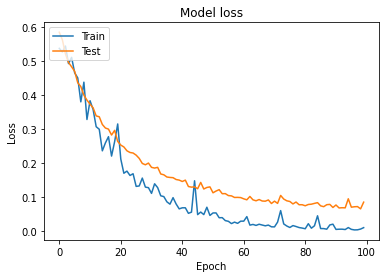

In [15]:
plt.plot(train_loss_history)
plt.plot(valid_loss_history)
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [17]:
import csv


with open("valid_loss_history.csv", 'w') as file:
  writer = csv.writer(file)
  writer.writerow(valid_loss_history)


In [16]:
import csv


with open("train_loss_history.csv", 'w') as file:
  writer = csv.writer(file)
  writer.writerow(train_loss_history)


In [18]:
true_label=[]
pred_label=[]

model=CustomConvNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=hyper_param_learning_rate)

checkpoint = torch.load('/home/sumins/workspace/model_check/model_val.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
print(loss)
custom_model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for item in test_loader:
        npys = item['npy'].to(device)
        labels = item['label'].to(device)
        
        outputs =model(npys)
        _, predicted = torch.max(outputs.data, 1)
        true_label.extend(labels)
        pred_label.extend(predicted)
        total += len(labels)
        correct += (predicted == labels).sum().item()
        
    print('Test Accuracy of the model on the {} test images: {} %'.format(total, 100 * correct / total))

tensor(0.0066, device='cuda:0', requires_grad=True)
Test Accuracy of the model on the 6663 test images: 97.4786132372805 %


In [19]:
true_labels=torch.tensor(true_label)
true_labels=true_labels.tolist()
pred_labels=torch.tensor(pred_label)
pred_labels=pred_labels.tolist()
print(classification_report(true_labels,pred_labels))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      4566
           1       0.97      0.95      0.96      2097

    accuracy                           0.97      6663
   macro avg       0.97      0.97      0.97      6663
weighted avg       0.97      0.97      0.97      6663

